# Orthogonal patch wise neural network


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from Quantum_circuits import *

In [2]:
# load a portion of the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:10000]
y_train = y_train[:10000]

x_test = x_test[:2500]
y_test = y_test[:2500]

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

In [3]:
# keep only 3 and 6
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 2046
Number of filtered test examples: 479


True


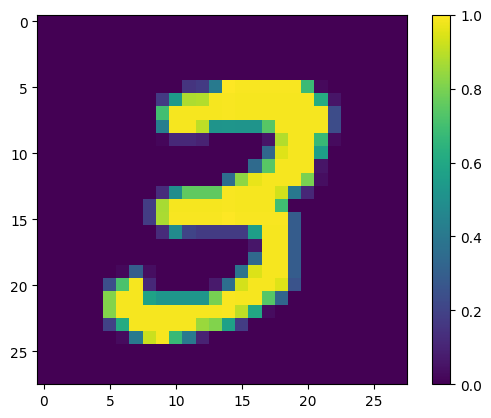

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [6]:
# resize the image to be 4x4
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


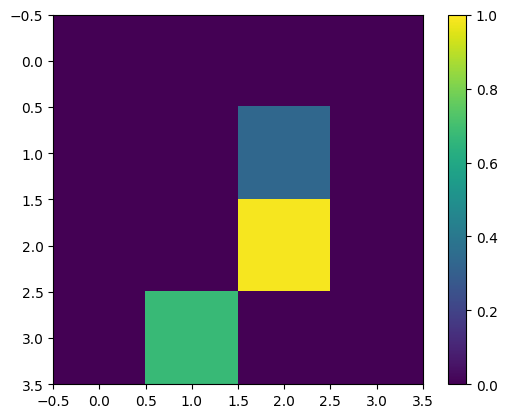

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [8]:
# remove contraddiction as suggested by tensorflow quantum documentation
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [9]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 1847
Number of unique 3s:  875
Number of unique 6s:  969
Number of unique contradicting labels (both 3 and 6):  3

Initial number of images:  2046
Remaining non-contradicting unique images:  1844


In [10]:
def patch_extractor(img):
    # Extracting 2x2 patches from the image
    patches = [
    tf.constant(img[0:2, 0:2]),  # Top-left
    tf.constant(img[0:2, 2:4]),  # Top-right
    tf.constant(img[2:4, 0:2]),  # Bottom-left
    tf.constant(img[2:4, 2:4])   # Bottom-right
    ]
    return patches

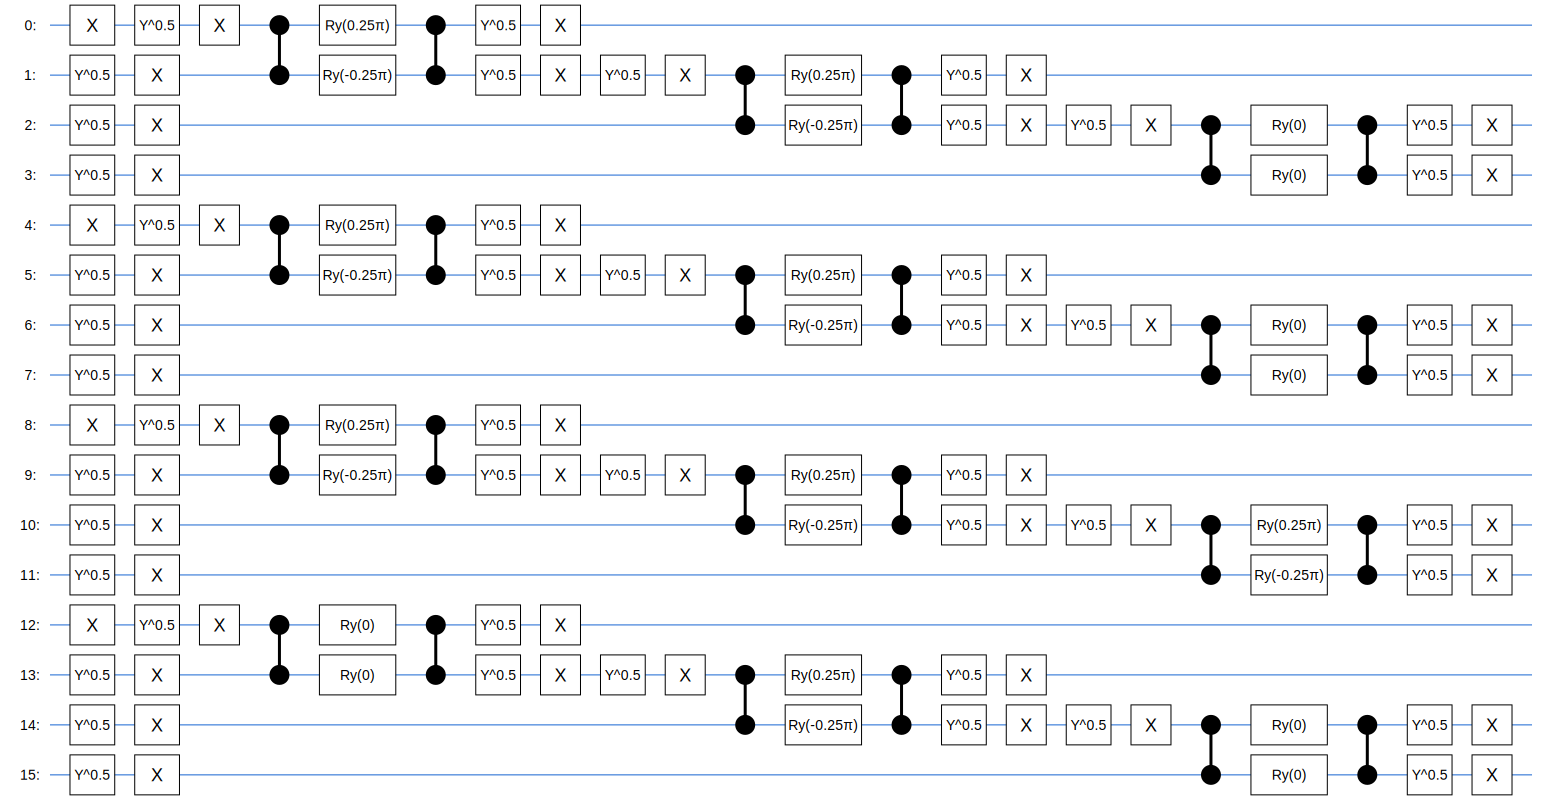

In [11]:
# loading patches as proposed in orthogonal patch wise implementation of Quantum Vision Transformers
def convert_to_circuit(image):
    #initialize circuit
    circuit = cirq.Circuit()
    qubits = [cirq.LineQubit(i) for i in range(16)]

    #divides the image into patches
    patches = patch_extractor(image)
    #load patches into the circuit
    for n in range(len(patches)):
        patch = patches[n]
        flat_patch = tf.reshape(patch, [-1]) 
        alphas = convert_array(flat_patch)
        vector_loader(circuit, alphas, is_x=True, is_conjugate=False, wires=qubits[n*4: 4 + n*4])
    return cirq.Circuit(cirq.decompose(circuit))
SVGCircuit(convert_to_circuit(x_train_nocon[0]))

In [12]:
x_train_tfcirc = tfq.convert_to_tensor([convert_to_circuit(x) for x in x_train_nocon])
x_test_tfcirc = tfq.convert_to_tensor([convert_to_circuit(x) for x in x_test_small])

In [13]:
# rbs gate implemented following Quantum Vision Transformers paper description
def build_rbs(circuit, q0, q1, symbol):
    circuit.append(cirq.Moment([cirq.H(q0), cirq.H(q1)]))
    circuit.append(cirq.CZ(q0, q1))
    circuit.append(cirq.Moment([cirq.ry(symbol / 2)(q0), cirq.ry(-symbol / 2)(q1)]))
    circuit.append(cirq.CZ(q0, q1))
    circuit.append(cirq.Moment([cirq.H(q0), cirq.H(q1)]))

In [14]:
# butterfly circuit implemented following Quantum Vision Transformers paper description
def butterfly_circuit(circuit, parameters, wires=None):
    # If wires is None, use all qubits in the circuit
    if wires is None:
        wires = list(circuit.all_qubits())
        length = len(wires)
    else:
        # If wires is not None, ensure it's a list of qubits
        length = len(wires)
    if length > 1:
        n=length//2
        x = 0
        for i in range(n):
            build_rbs(circuit, wires[i], wires[i+n], parameters[x])
            x += 1
        butterfly_circuit(circuit, parameters[x: (len(parameters)//2 + x//2) ], wires = wires[:n])
        butterfly_circuit(circuit, parameters[(len(parameters)//2 + x//2):], wires = wires[n:])

In [15]:
# applies the same butterfly layer to all the loaded patches, simulating a trivial self attention mechanism
# then applies a pyramidal circuit that simulates a 16 to 1 neural network
class CircuitLayerBuilder():
    def __init__(self, data_qubits):
        self.data_qubits = data_qubits

    def add_layer(self, circuit, gate, prefix):
        for n in range(4):
            parameters = [sympy.Symbol(prefix + '-' + str(i)) for i in range(4)]
            butterfly_circuit(circuit, parameters, wires=self.data_qubits[n*4:n*4+4])
        for i in range(len(self.data_qubits) - 2, -1, -1):
            symbol = sympy.Symbol(prefix + '-' + str(i + 4)) 
            q0, q1 = self.data_qubits[i], self.data_qubits[i + 1]
            # Group operations that should execute simultaneously in a Moment
            build_rbs(circuit, q0, q1, symbol)
        circuit.append(cirq.X(self.data_qubits[0]))

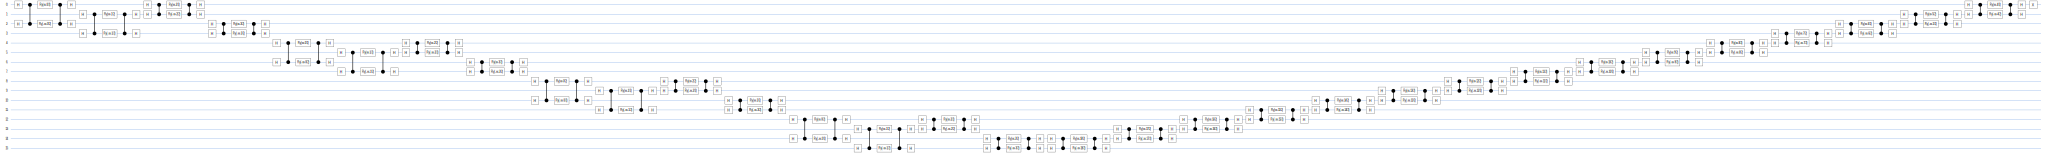

In [16]:
demo_builder = CircuitLayerBuilder(data_qubits = [cirq.LineQubit(i) for i in range(16)])

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

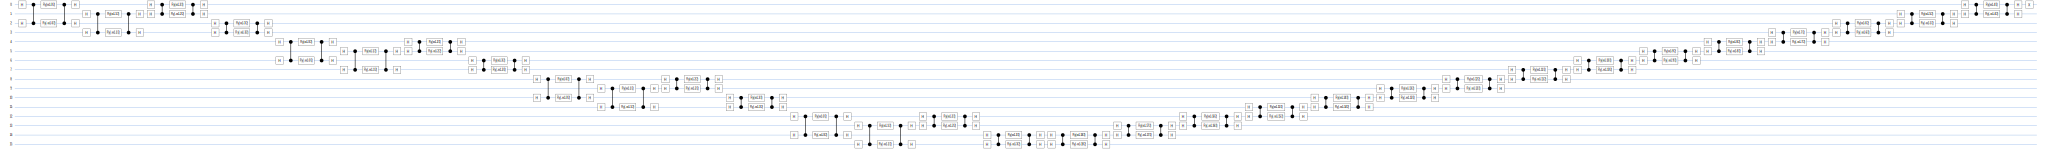

In [17]:
def create_quantum_model(num_qubits=16, layers=[("XX", cirq.XX)]):
    data_qubits = [cirq.LineQubit(i) for i in range(num_qubits)]
    circuit = cirq.Circuit()
    
    builder = CircuitLayerBuilder(data_qubits=data_qubits)
    
    for prefix, gate in layers:
        builder.add_layer(circuit, gate, prefix)
    
    readout = data_qubits[0]
    return circuit, cirq.Z(readout)

num_qubits = 16
layers = [("xx1", cirq.XX)]  
model_circuit, model_readout = create_quantum_model(num_qubits=num_qubits, layers=layers)

SVGCircuit(model_circuit)

In [18]:
model_circuit, model_readout = create_quantum_model()

In [19]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
    # custom layer to map the output to [0,1]
    tf.keras.layers.Lambda(lambda x: x/2 +0.5),
])

In [20]:
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] )

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 19        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
EPOCHS = 3
BATCH_SIZE = 32
NUM_EXAMPLES = min(len(x_train_tfcirc), len(y_train))

In [23]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_sub = y_train[:NUM_EXAMPLES]

In [ ]:
qnn_history = model.fit(
    x_train_tfcirc, y_train_nocon,  
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test_tfcirc, y_test))

Epoch 1/3
58/58 [==============================] - 73s 1s/step - loss: 0.1867 - accuracy: 0.7202 - auc: 0.8059 - val_loss: 0.1873 - val_accuracy: 0.7035 - val_auc: 0.9285
Epoch 2/3
58/58 [==============================] - 73s 1s/step - loss: 0.1326 - accuracy: 0.8482 - auc: 0.9338 - val_loss: 0.1313 - val_accuracy: 0.8852 - val_auc: 0.9399
Epoch 3/3
58/58 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.8991 - auc: 0.9502